<a href="https://colab.research.google.com/github/MiguelRoLopz/Redes_Neuronales_Convoluciones_LosSimpsons/blob/main/Actividad_2_Redes_Neuronales_Convolucionales_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ACTIVIDAD 2: REDES NEURONALES CONVOLUCIONALES

---

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [3]:
import cv2
import os
import numpy as np
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf



In [4]:
# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz",
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets


# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz",
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

In [5]:
# Descomprimimos el archivo en tmp para visualizar
# !tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /tmp/simpsons

In [6]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [7]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.

    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [8]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [9]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [10]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

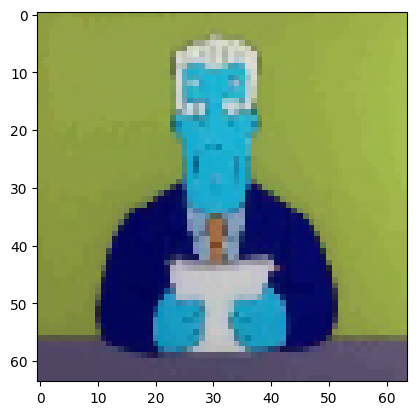

In [11]:
plt.imshow(X_t[2]) # recordad que siempre es preferible trabajar en blanco y negro


## Ejercicio

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas:
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

# Análisis y preparación de datos
El dataset utilizado contiene imágenes de 18 personajes de Los Simpsons organizadas en carpetas por cada personaje. En el código base mostrado anteriormente hemos descargado y descrompimido el dataset, además de redimensionar las imágenes a un tamaño estándar de 64x64 píxeles.
Las imágenes se cargan y redimensionan utilizando las funciones 'load_train_set' y 'load_test_set' para, posteriormente, barajar los datos de forma aleatoria para evitar sesgos durante el entrenamiento y la validación del modelo.

Tras ello, realizamos los siguinetes pasos:
### Normalización
Las imágenes se normalizan para escalar los valores a un rango de 0 a 1.
### División del conjunto en datos de entremiento y test
Importamos la función 'train_test_split' de la biblioteca scikit-learn para dividir el conjunto de datos en un 80% para entrenamiento y un 20% para validación. De esta forma intentaremos lograr una buena estimación del rendimiento requerido. Utilizamos la semilla predeterminada (42) para garantizar reproducibilidad.
Para verificar que las divisiones de datos se han realizado correctamente, imprimiremos las dimesiones de los conjuntos resultantes.

In [12]:
# Normalización
X = X/255.0
X_t = X_t/255.0

# Entrenamiento y Test
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamaño del conjunto de entrenamiento:", X_train.shape, y_train.shape)
print("Tamaño del conjunto de validación:", X_val.shape, y_val.shape)

Tamaño del conjunto de entrenamiento: (15193, 64, 64, 3) (15193,)
Tamaño del conjunto de validación: (3799, 64, 64, 3) (3799,)


# Análisis de resultados
### Construcción de la red neuronal convolucional (CNN) utilizando Keras
La arquitectura del modelo incluye varias capas convolucionales seguidas de capas max-pooling para reducir la dimensionalidad en las salidas de las capas de convolución. Además, incluimos una capa Flatten, una capa Dense completamente conectada y una capa de salida con el número de instancias a clasificar (18 personajes de Los Simpsons) con una función de activación Softmax.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)), # Tamaño de imagenes de 64x64
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(18, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Entrenamiento del modelo
Establecemos los parámetros de entrenamiento para intentar optimizar el rendimiento del modelo.

· Optmizador Adam para lograr una convergencia rápida y robustez en la solución, además de la adaptación de la tasa de aprendizaje en cada iteración para cada parámetro.

· Entropía cruzada para problemas multiclase (18 personajes)

In [14]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/10
475/475 [==============================] - 12s 12ms/step - loss: 1.9460 - accuracy: 0.4062 - val_loss: 1.2338 - val_accuracy: 0.6391
Epoch 2/10
475/475 [==============================] - 3s 7ms/step - loss: 1.0334 - accuracy: 0.6908 - val_loss: 0.7851 - val_accuracy: 0.7663
Epoch 3/10
475/475 [==============================] - 4s 8ms/step - loss: 0.6718 - accuracy: 0.7964 - val_loss: 0.6172 - val_accuracy: 0.8286
Epoch 4/10
475/475 [==============================] - 4s 8ms/step - loss: 0.4611 - accuracy: 0.8570 - val_loss: 0.5472 - val_accuracy: 0.8457
Epoch 5/10
475/475 [==============================] - 4s 8ms/step - loss: 0.3084 - accuracy: 0.9081 - val_loss: 0.6007 - val_accuracy: 0.8410
Epoch 6/10
475/475 [==============================] - 3s 7ms/step - loss: 0.2082 - accuracy: 0.9339 - val_loss: 0.5501 - val_accuracy: 0.8605
Epoch 7/10
475/475 [==============================] - 3s 7ms/step - loss: 0.1650 - accuracy: 0.9468 - val_loss: 0.5583 - val_accuracy: 0.8692
Epoc

# Evaluación del modelo
Comprobamos métricas del modelo como la precisión, el recall y el F1-score para cada clase del dataset, es decir, para cada personaje de Los Simpsons analizado.

In [15]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_t)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_t, y_pred_classes, target_names=[v for k, v in MAP_CHARACTERS.items()]))

28/28 [==============================] - 0s 9ms/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.98      0.94      0.96        48
  apu_nahasapeemapetilon       0.96      1.00      0.98        50
            bart_simpson       0.88      0.92      0.90        50
charles_montgomery_burns       0.94      0.92      0.93        48
            chief_wiggum       1.00      0.98      0.99        50
          comic_book_guy       0.98      0.94      0.96        49
          edna_krabappel       1.00      0.92      0.96        50
           homer_simpson       1.00      0.98      0.99        50
           kent_brockman       0.98      0.94      0.96        50
        krusty_the_clown       0.98      1.00      0.99        50
            lisa_simpson       0.92      0.92      0.92        50
           marge_simpson       1.00      0.98      0.99        50
     milhouse_van_houten       1.00      0.92      0.96        49
             moe_szysl

# Análisis de resultados
El informe de clasificación muestras las métricas de precisión, recall, F1-score y soporte para cada clase del dataset.

Podemos comprobar de forma sencilla que se cumplen sobradamente los requisitos de precisión (accuracy) superiores al 85%, llegando en algunos casos a una precisión del modelo del 100%. De media, nuestro modelo tiene una precisión del 96%.

Si analizamos los resultados por clases, podemos observar que los personajes chief_wiggum, homer_simpson y marge_simpson (por ejemplo), tienen unas métricas de rendimiento casi perfectas, lo que nos indica que el modelo identifica personajes sin comerter prácticamente errores en la clasificación.

Por otro lado, la clase principal_skinner es la que peor ha clasificado nuestro modelo, aunque también tiene un excepcional rendimiento superior al 83% de precisión y con un recall del 100%. La precisión del 83% es un indicador de que el modelo clasifica imagenes del director Skinner incorrectamente (Falsos Positivos) de forma más frecuente que para otras clases.

Para mejorar el modelo podríamos aumentar los datos para clases con peores métricas y así mejorar los entrenamientos para una mejora posterior en la clasificación. El ajuste de hiperparámetros se ha realizado previamente y la configuración establecida es la que mejores resultados ha ofrecido.